from torchvision.utils import make_grid# <font style="color:blue">Project 2: Kaggle Competition - Classification</font>

#### Maximum Points: 100

<div>
    <table>
        <tr><td><h3>Sr. no.</h3></td> <td><h3>Section</h3></td> <td><h3>Points</h3></td> </tr>
        <tr><td><h3>1</h3></td> <td><h3>Data Loader</h3></td> <td><h3>10</h3></td> </tr>
        <tr><td><h3>2</h3></td> <td><h3>Configuration</h3></td> <td><h3>5</h3></td> </tr>
        <tr><td><h3>3</h3></td> <td><h3>Evaluation Metric</h3></td> <td><h3>10</h3></td> </tr>
        <tr><td><h3>4</h3></td> <td><h3>Train and Validation</h3></td> <td><h3>5</h3></td> </tr>
        <tr><td><h3>5</h3></td> <td><h3>Model</h3></td> <td><h3>5</h3></td> </tr>
        <tr><td><h3>6</h3></td> <td><h3>Utils</h3></td> <td><h3>5</h3></td> </tr>
        <tr><td><h3>7</h3></td> <td><h3>Experiment</h3></td><td><h3>5</h3></td> </tr>
        <tr><td><h3>8</h3></td> <td><h3>TensorBoard Log</h3></td> <td><h3>5</h3></td> </tr>
        <tr><td><h3>9</h3></td> <td><h3>Kaggle Profile Link</h3></td> <td><h3>50</h3></td> </tr>
    </table>
</div>


In [1]:
!pip install --quiet lightning
!pip install --quiet albumentations

In [2]:
# Standard Library imports
from pathlib import Path
from dataclasses import dataclass
import os

# External imports
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt

import albumentations as A
from albumentations.pytorch import ToTensorV2

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.modules.batchnorm import _BatchNorm
from torch.utils.data import Dataset, DataLoader

import lightning as pl
from lightning.pytorch.loggers import CSVLogger, TensorBoardLogger
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
from lightning.pytorch.callbacks import BackboneFinetuning, BaseFinetuning

from torchmetrics import MeanMetric
from torchmetrics.classification import MulticlassAccuracy
from torchmetrics.classification import MulticlassConfusionMatrix

from torchvision import models, datasets, transforms
from torchvision.utils import make_grid


In [3]:
@dataclass(frozen=True)
class TrainingConfiguration:
    '''
    Describe configuration of the training process
    '''
    MODEL_NAME: str = "resnet50"
    WEIGHTS: str = "DEFAULT"
    EPOCHS: int = 1
    WARMUP_EPOCHS: int = 10
    LR: float = 1e-2
    WEIGHT_DECAY:float = 1e-5
    PRECISION: str = "16-mixed"
    TRAIN_SPLIT: float = 0.75
    BATCH_SIZE: int = 32
    PATIENCE: int = 10
    LAYERS= [4, 5, 6, 7]  # Possible values: 4, 5, 6, 7
    FAST_DEV_RUN = False
    LOAD_MODEL = True
    TRAINED_MODEL_PATH = "/kaggle/input/resnet50-epoch-227/fine-tuning-resnet50-epoch-227.ckpt"
    
@dataclass(frozen=True)
class DataConfiguration:
    ROOT_FOLDER: str = "/kaggle/input/opencv-pytorch-classification-project-2"
    NUM_CORKERS: int = 4
    NUM_CLASSES:int = 13
    TARGET_SIZE: int = 256
        
train_config = TrainingConfiguration()
data_config = DataConfiguration()

## <font style="color:green">1. Data Loader [10 Points]</font>

In [4]:
class KenyanFood13Dataset(Dataset):
    """
    Generic Dataset class for semantic segmentation datasets.
    """

    def __init__(
        self,
        data_path,
        images_folder,
        image_ids,
        labels=None,
        transforms=None,
    ):

        self.data_path = data_path
        self.images_folder = images_folder
        self.image_ids = image_ids
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        label = self.labels[idx] if self.labels is not None else None

        # Get image 
        image_path = os.path.join(self.data_path, self.images_folder, f"{image_id}.jpg")

        # Load image
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
           
        #For the prediction step
        if label is None:
            label = str(image_id)
            
        if self.transforms is not None:
            transformed = self.transforms(image=image)
            return transformed['image'], label
        
        return image, label

In [5]:
class KenyaDataModule(pl.LightningDataModule):

    def __init__(self, batch_size, num_workers=1):
        super().__init__()
        
        self.batch_size = batch_size
        self.num_workers = num_workers
        
        self.common_transforms = A.Compose(
            [
                A.Resize(height=data_config.TARGET_SIZE, width=data_config.TARGET_SIZE, p=1),
                A.CenterCrop(height=224, width=224, p=1),
                A.Normalize(),
                ToTensorV2(),
            ]
        )

        self.train_transforms = A.Compose(
            [
                #A.RandomResizedCrop(data_config.TARGET_SIZE, data_config.TARGET_SIZE),
                A.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.3),
                A.ToGray(p=0.1),
                A.HorizontalFlip(),
                A.VerticalFlip(),
                A.RandomRotate90(),
                A.ShiftScaleRotate(
                    border_mode=cv2.BORDER_CONSTANT,
                    rotate_limit=10,
                    scale_limit=0.0,
                    value=0,
                    p=0.75,
                ),
                A.ElasticTransform(
                    alpha=120,
                    sigma=6,
                    alpha_affine=8,
                    border_mode=cv2.BORDER_CONSTANT,
                    value=0,
                    interpolation=cv2.INTER_LINEAR,
                    p=0.5,
                ),
                A.GridDistortion(
                    num_steps=5,
                    distort_limit=0.05,
                    border_mode=cv2.BORDER_CONSTANT,
                    value=0,
                    interpolation=cv2.INTER_LINEAR,
                    p=0.5,
                ),
                self.common_transforms
            ]
        )

        self.valid_transforms = A.Compose([self.common_transforms])
        self.test_transforms = A.Compose([self.common_transforms])

    def prepare_data(self):
        """
        This function handles downloads and any data processing.
        This function makes sure that when you use multiple GPUs,
        you don't download multiple datasets or apply double manipulations to the data.
        """
        pass

    def setup(self, stage=None):

        train_csv_path = Path(data_config.ROOT_FOLDER) / "train.csv"
        test_csv_path = Path(data_config.ROOT_FOLDER) / "test.csv"

        train_df = pd.read_csv(train_csv_path)
        test_df = pd.read_csv(test_csv_path)
        
        self.whole_dataset = KenyanFood13Dataset(
            data_config.ROOT_FOLDER,
            "images/images",
            train_df.id,
        )

        # Encode classes as integers
        self.le = LabelEncoder()
        y = self.le.fit_transform(train_df["class"])
        y = torch.Tensor(y).to(torch.int64)
        
        # Image ids
        X = train_df.id
               
        # Stratified split into training and validation sets
        sss = StratifiedShuffleSplit(n_splits=1, train_size=train_config.TRAIN_SPLIT, random_state=0)
        for train_index, valid_index in sss.split(X, y):
            train_ids, valid_ids, train_y, valid_y = X[train_index], X[valid_index], y[train_index], y[valid_index]

        test_ids = test_df.id
        
        self.train_dataset = KenyanFood13Dataset(
            data_config.ROOT_FOLDER,
            "images/images",
            train_ids.tolist(),
            labels=train_y,
            transforms=self.train_transforms,
        )
        
        self.valid_dataset = KenyanFood13Dataset(
            data_config.ROOT_FOLDER,
            "images/images",
            valid_ids.tolist(),
            labels=valid_y,
            transforms=self.valid_transforms,
        )

        self.predict_dataset = KenyanFood13Dataset(
            data_config.ROOT_FOLDER,
            "images/images",
            test_ids.tolist(),
            transforms=self.test_transforms,
        )

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            drop_last=True,
            num_workers=self.num_workers,
        )

    def val_dataloader(self):
        return DataLoader(
            self.valid_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            drop_last=True,
            num_workers=self.num_workers,
        )

    def predict_dataloader(self):
        return DataLoader(
            self.predict_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            drop_last=True,
            num_workers=self.num_workers,
        )

In [6]:
def denormalize(tensors):
    """
    Denormalize image tensors back to range [0.0, 1.0]
    
    From: Deep Learning with PyTorch - OpenCV University
    """

    mean = torch.Tensor([0.485, 0.456, 0.406])
    std = torch.Tensor([0.229, 0.224, 0.225])
    
    tensors = tensors.clone()
    for c in range(3):
        tensors[:, c, :, :].mul_(std[c]).add_(mean[c])

    return torch.clamp(tensors.cpu(), 0.0, 1.0)

### Visualize some augmented images 

The normalization is removed to be able to perceive the other transformations

Images batch shape: torch.Size([25, 3, 224, 224])
Labels batch shape: torch.Size([25])


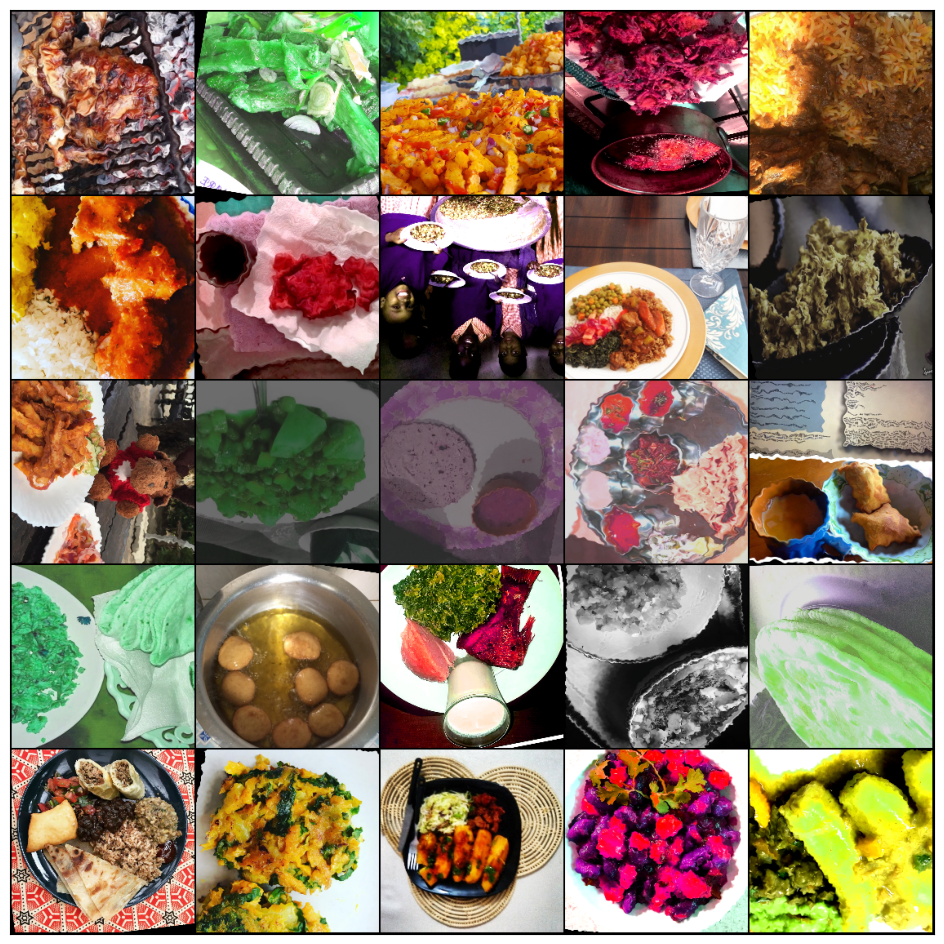

In [7]:
dm = KenyaDataModule(batch_size=25)
dm.setup()

dataloader = dm.train_dataloader()

images, labels = next(iter(dataloader))
print(f"Images batch shape: {images.size()}")
print(f"Labels batch shape: {labels.size()}")

fig, ax = plt.subplots(figsize=(12,12))
ax.set_xticks([]); ax.set_yticks([])

images = denormalize(images)

ax.imshow(make_grid(images, nrow=5).permute(1, 2, 0))
plt.show()

## <font style="color:green">4. Train and Validation [5 Points]</font>


In [8]:
class FineTuningWithResNet(pl.LightningModule):
    def __init__(
        self,
        resnet_model_name="resnet18",
        weights="DEFAULT",
        learning_rate=0.01,
        num_classes=10,
    ):
        """
        Modified from: Deep Learning with PyTorch - OpenCV University
        """
        
        super().__init__()

        self.save_hyperparameters()

        # Init the backbone of a pretrained Resnet
        resnet = getattr(models, self.hparams.resnet_model_name)(weights=self.hparams.weights)
        layers = list(resnet.children())[:-1]
        self.backbone = nn.Sequential(*layers)
        
        # Add a classifier head
        self.classifier = nn.Linear(in_features=resnet.fc.in_features, out_features=self.hparams.num_classes)

        # Initializing the required metric objects.
        self.mean_train_loss = MeanMetric()
        self.mean_train_acc = MulticlassAccuracy(num_classes=self.hparams.num_classes, average="micro")
        self.mean_valid_loss = MeanMetric()
        self.mean_valid_acc = MulticlassAccuracy(num_classes=self.hparams.num_classes, average="micro")
        
        self.confusion_matrix = MulticlassConfusionMatrix(num_classes=self.hparams.num_classes)


    
    def forward(self, x):
        """ """
        x = self.backbone(x).flatten(1)
        x = self.classifier(x)
        return x


    def training_step(self, batch, *args, **kwargs):
        """ """
        
        data, target = batch

        # Get prediction
        output = self(data)

        # Calculate batch loss
        loss = F.cross_entropy(output, target)

        # Batch Predictions
        pred_batch = output.detach().argmax(dim=1)

        self.mean_train_loss.update(loss, weight=data.shape[0])
        self.mean_train_acc.update(pred_batch, target)

        # self.log("train/batch_loss", self.mean_train_loss, prog_bar=True, logger=True)
        # self.log("train/batch_acc", self.mean_train_acc, prog_bar=True, logger=True)

        return loss

    
    def on_train_epoch_end(self):
        """Calculate epoch level metrics for the train set"""
        
        self.log("train/loss", self.mean_train_loss, prog_bar=True, logger=True)
        self.log("train/acc", self.mean_train_acc, prog_bar=True, logger=True)
        self.log("step", self.current_epoch, logger=True)

    
    def validation_step(self, batch, *args, **kwargs):
        """ """
        
        data, target = batch

        # get prediction
        output = self(data)

        loss = F.cross_entropy(output, target)

        # Batch Predictions
        pred_batch = output.argmax(dim=1)

        self.mean_valid_loss.update(loss, weight=data.shape[0])
        self.mean_valid_acc.update(pred_batch, target)
        self.confusion_matrix.update(pred_batch, target)
    
    
    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        data, imageid = batch
        output = self(data)
        pred = output.detach().argmax(dim=1)
        return imageid, pred
        

    def on_validation_epoch_end(self):
        """Calculate epoch level metrics for the validation set"""

        self.log("valid/loss", self.mean_valid_loss, prog_bar=True, logger=True)
        self.log("valid/acc", self.mean_valid_acc, prog_bar=True, logger=True)
        self.log("step", self.current_epoch, logger=True)

        
    def configure_optimizers(self):
        """ """
        
        optimizer = torch.optim.SGD(self.parameters(), lr=self.hparams.learning_rate, weight_decay=train_config.WEIGHT_DECAY)
        
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=train_config.LR,
            steps_per_epoch=self.trainer.estimated_stepping_batches,
            epochs=train_config.EPOCHS,
        )
        
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                # The unit of the scheduler's step size, could also be 'step'.
                # 'epoch' updates the scheduler on epoch end whereas 'step'
                # updates it after a optimizer update.
                "interval": "step",
                # How many epochs/steps should pass between calls to `scheduler.step()`.
                # 1 corresponds to updating the learning rate after every epoch/step.
                "frequency": 1,
                # Metric to to monitor for schedulers like `ReduceLROnPlateau`
                "monitor": "valid/loss",
                # If set to `True`, will enforce that the value specified 'monitor'
                # is available when the scheduler is updated, thus stopping
                # training if not found. If set to `False`, it will only produce a warning
                "strict": True,
                # If using the `LearningRateMonitor` callback to monitor the
                # learning rate progress, this keyword can be used to specify
                # a custom logged name
                "name": None,
            },
        }

    
    def unfreeze_head(self):
        """
        This is not overriding anything, it's just a method I created.
        """

        for param in self.classifier.parameters():
            param.requires_grad = True

    
    def unfreeze_backbone_layers(self, layers: list[int]):
        """
        This is not overriding anything, it's just a method I created.
        """

        # self.backbone has 4 Sequential layers, from backbone[4] to backbone[7]
        for l in layers:
            backbone_layer = self.backbone[l]
            modules = BaseFinetuning.flatten_modules(backbone_layer)
                            
            for module in modules:
                if isinstance(module, _BatchNorm):
                    module.track_running_stats = True
                # recursion could yield duplicate parameters for parent modules w/ parameters so disabling it
                for param in module.parameters(recurse=False):
                    param.requires_grad = True

    
    def freeze_backbone(self):
        """ """
        BaseFinetuning.freeze(self.backbone, train_bn=False)

In [9]:
data_module = KenyaDataModule(
    batch_size=train_config.BATCH_SIZE,
    num_workers=data_config.NUM_CORKERS
)

In [10]:
checkpoint_callback = ModelCheckpoint(
    monitor='valid/acc',
    mode="max",
    filename='fine-tuning-resnet50-epoch-{epoch:02d}',
    auto_insert_metric_name=False,
    save_weights_only=True
)


early_stopping_callback = EarlyStopping(
    monitor="valid/loss",
    min_delta=1e-3,
    patience=train_config.PATIENCE
)


callbacks=[
    early_stopping_callback,                                                         
    checkpoint_callback,
]

In [11]:
trainer = pl.Trainer(
    accelerator="auto", 
    devices="auto",  
    strategy="auto", 
    max_epochs=train_config.EPOCHS,  
    precision = train_config.PRECISION,
    #log_every_n_steps=10,
    callbacks=callbacks,
    logger=TensorBoardLogger("logs", name=train_config.MODEL_NAME),
    accumulate_grad_batches=1,
    fast_dev_run=train_config.FAST_DEV_RUN,
    #limit_train_batches=1,
    #limit_val_batches=1,
)

INFO: Using 16bit Automatic Mixed Precision (AMP)
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs


## <font style="color:green">7. Experiment [5 Points]</font>


In [12]:
if train_config.LOAD_MODEL:
    
    if Path(train_config.TRAINED_MODEL_PATH).exists():
        model = FineTuningWithResNet.load_from_checkpoint(train_config.TRAINED_MODEL_PATH)
        model.freeze_backbone()
        model.unfreeze_backbone_layers(train_config.LAYERS)
        model.unfreeze_head()
        print(f"Model loaded: '{train_config.TRAINED_MODEL_PATH}'")
    
    else:
        raise Exception("Model doesn't exist")

else:
    model = FineTuningWithResNet(
        resnet_model_name=train_config.MODEL_NAME,
        weights=train_config.WEIGHTS,
        num_classes=data_config.NUM_CLASSES,
        learning_rate=train_config.LR,
    )
    
    model.freeze_backbone()
    
    trainer.fit_loop.max_epochs=train_config.WARMUP_EPOCHS

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 174MB/s]


Model loaded: '/kaggle/input/resnet50-epoch-227/fine-tuning-resnet50-epoch-227.ckpt'


In [13]:
pl.seed_everything(21, workers=True)
trainer.fit(model, data_module)

INFO: Seed set to 21
2024-06-09 06:16:53.831722: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-09 06:16:53.831819: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-09 06:16:53.954651: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loading `train_dataloader` to estimate number of stepping batches.
INFO: 
  | Name             | Type                      | Params
---------------------------------------------------------------
0 | backbone         | Sequential                | 23.5 M
1 | classifier       | Linear       

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=1` reached.


In [14]:
model = FineTuningWithResNet.load_from_checkpoint(checkpoint_callback.best_model_path)
model.eval()
model.freeze()

In [15]:
trainer.validate(model, data_module)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           step            │            1.0            │
│         valid/acc         │    0.7279411554336548     │
│        valid/loss         │    0.8464375734329224     │
└───────────────────────────┴───────────────────────────┘

[{'valid/loss': 0.8464375734329224,
  'valid/acc': 0.7279411554336548,
  'step': 1.0}]

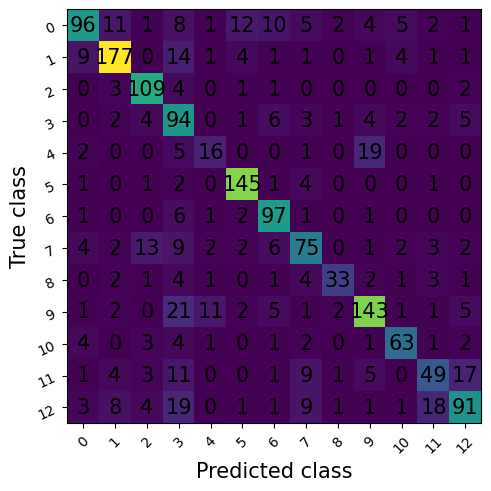

In [16]:
fig_, ax_ = model.confusion_matrix.plot()

### Prepare predictions

In [17]:
results = trainer.predict(model, data_module)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [18]:
predictions = []
imageids = []
for res in results:
    ids, preds = res
    imageids.extend(ids)
    predictions.extend(preds.tolist())
    
predictions = data_module.le.inverse_transform(predictions)
df = pd.DataFrame({"id":imageids, "class":predictions})
df.to_csv("predictions.csv", index=False)
print(df)

                        id       class
0      9156739011499789258  nyamachoma
1      2049465964503133373  kachumbari
2      6446998501027132988  nyamachoma
3      4194396063119815321       ugali
4      9018117998187006009  kachumbari
...                    ...         ...
1633  18302448610371772604     githeri
1634  15920672464676076400     chapati
1635   3232020170382870007     chapati
1636   3094804487341098468  kachumbari
1637   5827342261332058667       ugali

[1638 rows x 2 columns]


## <font style="color:green">9. Kaggle Profile Link [50 Points]</font>


**For full points, you need a minimum accuracy of `75%` on the test data. If accuracy is less than `70%`, you gain  no points for this section.**


https://www.kaggle.com/mclzc89